In [41]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator

from global_params import *
from sklearn.metrics import r2_score

In [11]:


# ==params
n_input = 5
n_features = 1

# ==helper
def split(ts):
    size = int(len(ts) * 0.85)
    train = ts[:size]
    test = ts[size:]
    return (train, test)


# ==experiment
data = pd.read_csv(
    str(BASEPATH / pathlib.Path("Data/raw/COVID19Cases/StateLevels/us-states.csv"))
)  # (18824, 5)

df_by_date = pd.DataFrame(
    data.fillna("NA")
    .groupby(["state", "date"])["cases"]
    .sum()
    .sort_values()
    .reset_index()
)
case_by_date_florida = df_by_date[df_by_date["state"] == "Florida"]
# print(case_by_date_florida)
# print(case_by_date_florida.shape)
# exit()

case_by_date_florida_np = case_by_date_florida.to_numpy()[:, 2:].astype('float32')
# print(case_by_date_florida_np)
# print(case_by_date_florida_np.shape)
# exit()

case_by_date_florida_np = np.reshape(case_by_date_florida_np, (-1, 1))
# print(NtsC.shape
# exit()

case_by_date_florida_train, case_by_date_florida_test = split(case_by_date_florida_np)
# print(case_by_date_florida_train.shape)
# print(case_by_date_florida_test.shape)
# exit()


# test2 = np.reshape(test, (-1, 1))
generator_train = TimeseriesGenerator(
    case_by_date_florida_train, case_by_date_florida_train, length=n_input, batch_size=1
)
# print(list(generator))


In [14]:
model = Sequential()
model.add(LSTM(150, activation="relu", input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
# print(model.summary())
# exit()

Epoch 1/25
287/287 [==============================] - 1s 4ms/step - loss: 22957969408.0000
Epoch 2/25
287/287 [==============================] - 1s 4ms/step - loss: 1119555840.0000
Epoch 3/25
287/287 [==============================] - 1s 4ms/step - loss: 489870688.0000
Epoch 4/25
287/287 [==============================] - 1s 4ms/step - loss: 1479666944.0000
Epoch 5/25
287/287 [==============================] - 1s 4ms/step - loss: 1154280064.0000
Epoch 6/25
287/287 [==============================] - 1s 4ms/step - loss: 925810560.0000
Epoch 7/25
287/287 [==============================] - 1s 4ms/step - loss: 346556736.0000
Epoch 8/25
287/287 [==============================] - 1s 4ms/step - loss: 874333440.0000
Epoch 9/25
287/287 [==============================] - 1s 4ms/step - loss: 245315840.0000
Epoch 10/25
287/287 [==============================] - 1s 4ms/step - loss: 167640368.0000
Epoch 11/25
287/287 [==============================] - 1s 4ms/step - loss: 179964384.0000
Epoch 12/25
28

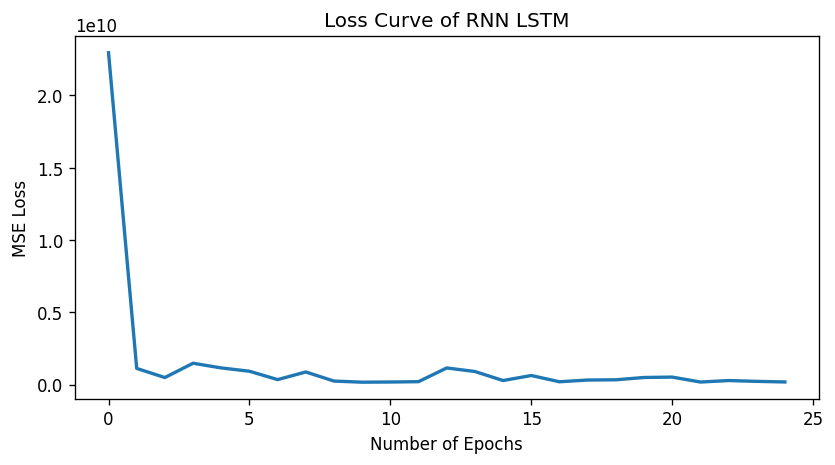

In [15]:
model.fit_generator(generator_train, epochs=25)
loss_per_epoch = model.history.history["loss"]
fig = plt.figure(dpi=120, figsize=(8, 4))
ax = plt.axes()
ax.set(xlabel="Number of Epochs", ylabel="MSE Loss", title="Loss Curve of RNN LSTM")
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, lw=2)

In [17]:
test_predictions = []

first_eval_batch = case_by_date_florida_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(case_by_date_florida_test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)     
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [18]:
test_predictions=np.ravel(test_predictions)

In [19]:
pred=pd.DataFrame(columns={"current","prediction"})

In [22]:
test_predictions.shape

(52,)

In [23]:
case_by_date_florida_test.shape

(52, 1)

In [24]:
pred["current"]=case_by_date_florida_test.reshape(-1)
pred["prediction"]=test_predictions

In [27]:
pred.head()

,current,prediction
0,1181475.0,1165733.625
1,1193157.0,1174665.250
2,1201558.0,1183722.125
3,1212573.0,1192775.250
4,1223007.0,1199801.375


In [28]:
dd=pd.DataFrame(columns=['MAPE','MSE','RMSE'])

In [42]:
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def mse(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean((y1 - y_pred)**2)

def rmse(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.sqrt(np.mean((y1 - y_pred)**2))
def r2score(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return r2_score(y1, y_pred)

In [43]:
print("Mean absolute % error using LSTM: ",mape(pred["current"],pred["prediction"]))
print("Mean Square Error error using LSTM: ",mse(pred["current"],pred["prediction"]))
print("Root Mean Square error using LSTM: ",rmse(pred["current"],pred["prediction"]))
print("R2 score using LSTM: ",r2score(pred["current"],pred["prediction"]))
dd=pd.DataFrame({'MAPE': [mape(pred["current"],pred["prediction"])], 'MSE': [mse(pred["current"],pred["prediction"])], 'RMSE': [rmse(pred["current"],pred["prediction"])]}, index=[1])

Mean absolute % error using LSTM:  7.225363701581955
Mean Square Error error using LSTM:  16500180000.0
Root Mean Square error using LSTM:  128453.02
R2 score using LSTM:  0.5325339506464277
